## Conexión con Google Drive

### Montar Google Drive y crear directorios

In [ ]:
from google.colab import drive
import os
from pathlib import Path

# Montamos Google Drive
drive.mount('/content/drive')

# Definimos la carpeta base de trabajo
BASE_DIR = Path('/content/drive/MyDrive/Grupo6_Cifrados')

# Creamos subdirectorios necesarios
TEXT_DIR = BASE_DIR / 'texts'
KEYS_DIR = BASE_DIR / 'keys'
OUTPUT_DIR = BASE_DIR / 'outputs'

for d in (TEXT_DIR, KEYS_DIR, OUTPUT_DIR):
    os.makedirs(d, exist_ok=True)

print("✅ Google Drive conectado correctamente.")
print("📁 Carpeta base:", BASE_DIR)


Mounted at /content/drive
✅ Google Drive conectado correctamente.
📁 Carpeta base: /content/drive/MyDrive/Grupo6_Cifrados


## Instalación de librerías necesarias

### Instalar dependencias (solo la primera vez)

In [ ]:
!pip install pycryptodome pandas tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 45.4 MB/s eta 0:00:00


## Importación de librerías y configuración inicial

In [ ]:
import os
import time
import random
import string
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from Crypto.Cipher import AES, PKCS1_OAEP
from Crypto.PublicKey import RSA
from Crypto.Random import get_random_bytes
import hashlib

# Configuración general
OVERWRITE_FILES = False   # Regenerar archivos de texto si ya existen
OVERWRITE_KEYS = False    # Regenerar claves si ya existen

# Cantidad de palabras por archivo (ajusta si no quieres tamaños grandes)
WORD_COUNTS = [10, 100, 1000, 10000, 100000, 10000000]

print("✅ Librerías importadas y configuración establecida.")


✅ Librerías importadas y configuración establecida.


## Generación y lectura de archivos de texto

In [ ]:
def generar_texto(palabras, ruta):
    """Genera un archivo de texto con 'palabras' aleatorias."""
    if ruta.exists() and not OVERWRITE_FILES:
        print(f"📄 El archivo {ruta.name} ya existe, se omitirá la generación.")
        return

    print(f"📝 Generando archivo con {palabras} palabras...")
    with open(ruta, 'w', encoding='utf-8') as f:
        for _ in range(palabras):
            palabra = ''.join(random.choices(string.ascii_lowercase, k=6))
            f.write(palabra + ' ')
    print("✅ Archivo generado correctamente.")

def leer_texto(ruta):
    """Lee el contenido de un archivo de texto."""
    with open(ruta, 'r', encoding='utf-8') as f:
        return f.read()


## Cifrado Simétrico – AES

### Funciones de cifrado y descifrado AES

In [ ]:
from Crypto.Cipher import AES

# Parámetros básicos
BLOQUE = 16  # Tamaño del bloque AES (bytes)

def pkcs7_pad(data: bytes) -> bytes:
    pad_len = BLOQUE - (len(data) % BLOQUE)
    return data + bytes([pad_len]) * pad_len

def pkcs7_unpad(data: bytes) -> bytes:
    pad_len = data[-1]
    return data[:-pad_len]

def generar_clave_iv_aes():
    """Genera una clave AES-256 y un IV."""
    clave = get_random_bytes(32)
    iv = get_random_bytes(16)
    return clave, iv

def cifrar_aes(texto, clave, iv):
    cipher = AES.new(clave, AES.MODE_CBC, iv)
    return cipher.encrypt(pkcs7_pad(texto))

def descifrar_aes(cifrado, clave, iv):
    cipher = AES.new(clave, AES.MODE_CBC, iv)
    return pkcs7_unpad(cipher.decrypt(cifrado))

## Cifrado Asimétrico – RSA

### Generación de claves y funciones RSA

In [ ]:
RSA_BITS = 2048  # Tamaño de clave

def generar_claves_rsa(priv_path, pub_path):
    if priv_path.exists() and pub_path.exists() and not OVERWRITE_KEYS:
        print("🔑 Claves RSA existentes, omitiendo generación.")
        return

    key = RSA.generate(RSA_BITS)
    with open(priv_path, 'wb') as f:
        f.write(key.export_key())
    with open(pub_path, 'wb') as f:
        f.write(key.publickey().export_key())
    print("✅ Claves RSA generadas correctamente.")

def cifrar_rsa(data, public_key):
    cipher = PKCS1_OAEP.new(public_key)
    chunk_size = public_key.size_in_bytes() - 42
    chunks = [data[i:i+chunk_size] for i in range(0, len(data), chunk_size)]
    return b''.join(cipher.encrypt(c) for c in chunks)

def descifrar_rsa(data, private_key):
    cipher = PKCS1_OAEP.new(private_key)
    chunk_size = private_key.size_in_bytes()
    chunks = [data[i:i+chunk_size] for i in range(0, len(data), chunk_size)]
    return b''.join(cipher.decrypt(c) for c in chunks)

## Función Hash – SHA-256

In [ ]:
def hash_sha256(data):
    """Devuelve el hash SHA-256 en formato hexadecimal."""
    return hashlib.sha256(data).hexdigest()

## Ejecución principal y medición de tiempos

In [ ]:
resultados = []

# Generamos o cargamos claves RSA
priv_rsa = KEYS_DIR / "rsa_priv.pem"
pub_rsa = KEYS_DIR / "rsa_pub.pem"
generar_claves_rsa(priv_rsa, pub_rsa)

# Cargamos las claves RSA
from Crypto.PublicKey import RSA
rsa_priv = RSA.import_key(open(priv_rsa, 'rb').read())
rsa_pub = RSA.import_key(open(pub_rsa, 'rb').read())

# Recorremos los tamaños solicitados
for n in WORD_COUNTS:
    ruta = TEXT_DIR / f"texto_{n}.txt"
    generar_texto(n, ruta)

    t0 = time.perf_counter()
    texto = leer_texto(ruta)
    t1 = time.perf_counter()
    T_E1 = t1 - t0

    data = texto.encode('utf-8')

    # ===== AES =====
    t0 = time.perf_counter()
    clave, iv = generar_clave_iv_aes()
    t1 = time.perf_counter()
    T_E2 = t1 - t0

    t0 = time.perf_counter()
    cifrado = cifrar_aes(data, clave, iv)
    t1 = time.perf_counter()
    T_E3 = t1 - t0

    t0 = time.perf_counter()
    descifrado = descifrar_aes(cifrado, clave, iv)
    t1 = time.perf_counter()
    T_E4 = t1 - t0

    resultados.append(["AES", n, len(data), len(cifrado), T_E1, T_E2, T_E3, T_E4, T_E1+T_E2+T_E3+T_E4])

    # ===== RSA =====
    t0 = time.perf_counter()
    cifrado_rsa = cifrar_rsa(data, rsa_pub)
    t1 = time.perf_counter()
    T_E3_rsa = t1 - t0

    t0 = time.perf_counter()
    descifrado_rsa = descifrar_rsa(cifrado_rsa, rsa_priv)
    t1 = time.perf_counter()
    T_E4_rsa = t1 - t0

    resultados.append(["RSA", n, len(data), len(cifrado_rsa), T_E1, 0, T_E3_rsa, T_E4_rsa, T_E1+T_E3_rsa+T_E4_rsa])

    # ===== HASH =====
    t0 = time.perf_counter()
    hash_val = hash_sha256(data)
    t1 = time.perf_counter()
    T_hash = t1 - t0

    resultados.append(["SHA-256", n, len(data), len(hash_val), T_E1, 0, T_hash, 0, T_E1 + T_hash])

print("✅ Proceso completo.")

🔑 Claves RSA existentes, omitiendo generación.
📄 El archivo texto_10.txt ya existe, se omitirá la generación.
📄 El archivo texto_100.txt ya existe, se omitirá la generación.
📄 El archivo texto_1000.txt ya existe, se omitirá la generación.
📄 El archivo texto_10000.txt ya existe, se omitirá la generación.
📄 El archivo texto_100000.txt ya existe, se omitirá la generación.
📝 Generando archivo con 10000000 palabras...
✅ Archivo generado correctamente.
✅ Proceso completo.


## Generar tabla resumen

In [ ]:
df = pd.DataFrame(resultados, columns=[
    "Algoritmo", "#Palabras", "#Caracteres_Entrada", "#Caracteres_Salida",
    "T-E1", "T-E2", "T-E3", "T-E4", "T-Total"
])

ruta_resumen = OUTPUT_DIR / "resumen_resultados.csv"
df.to_csv(ruta_resumen, index=False)

print("📊 Tabla resumen generada correctamente:")
print(df.head(10))
print("💾 Guardado en:", ruta_resumen)

📊 Tabla resumen generada correctamente:
  Algoritmo  #Palabras  #Caracteres_Entrada  #Caracteres_Salida      T-E1  \
0       AES         10                   70                  80  0.523272   
1       RSA         10                   70                 256  0.523272   
2   SHA-256         10                   70                  64  0.523272   
3       AES        100                  700                 704  0.531540   
4       RSA        100                  700                1024  0.531540   
5   SHA-256        100                  700                  64  0.531540   
6       AES       1000                 7000                7008  0.494354   
7       RSA       1000                 7000                8448  0.494354   
8   SHA-256       1000                 7000                  64  0.494354   
9       AES      10000                70000               70016  0.550089   

       T-E2      T-E3      T-E4   T-Total  
0  0.000021  0.006802  0.000106  0.530201  
1  0.000000  0.001248  0

## Visualización de resultados (gráficas)

### Gráficas de tiempos por algoritmo

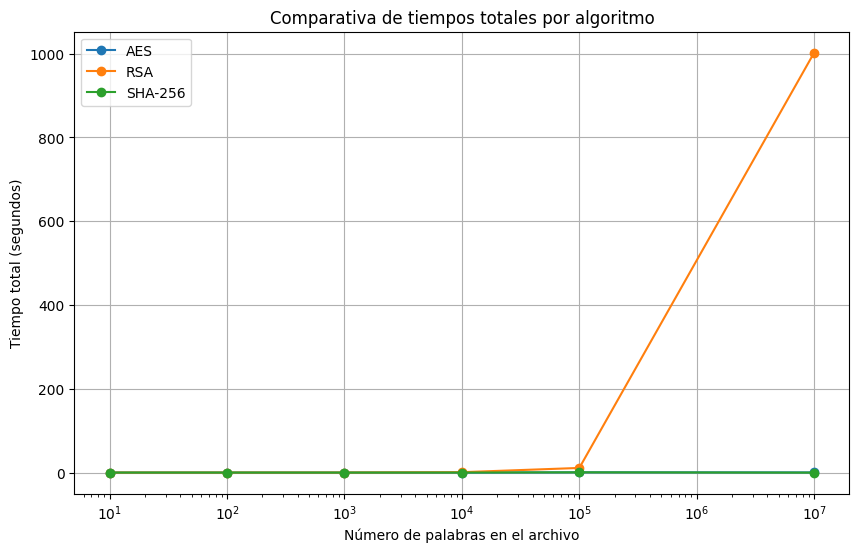

In [ ]:
import matplotlib.pyplot as plt

# Agrupamos por algoritmo
agrupado = df.groupby("Algoritmo")

plt.figure(figsize=(10,6))

for nombre, grupo in agrupado:
    plt.plot(grupo["#Palabras"], grupo["T-Total"], marker='o', label=nombre)

plt.title("Comparativa de tiempos totales por algoritmo")
plt.xlabel("Número de palabras en el archivo")
plt.ylabel("Tiempo total (segundos)")
plt.legend()
plt.grid(True)
plt.xscale('log')  # Escala logarítmica para ver mejor las diferencias
plt.show()


### Gráficas individuales por etapas

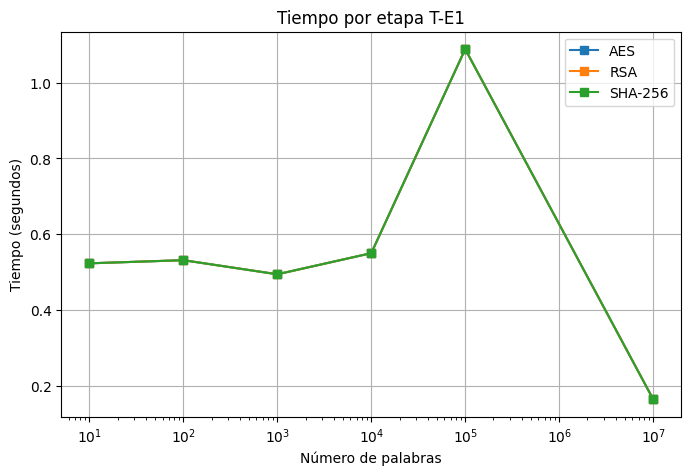

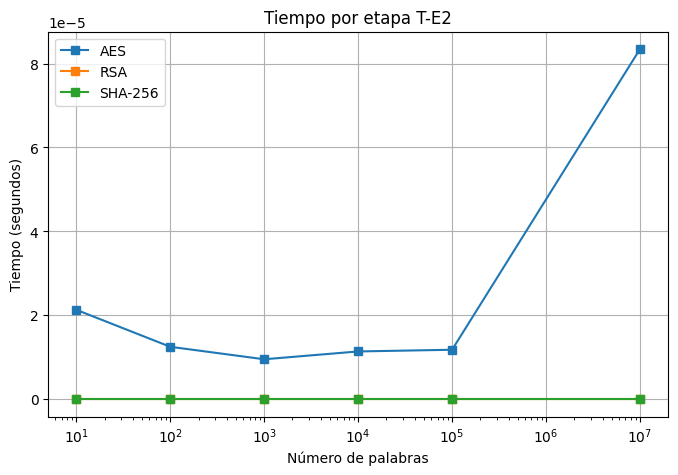

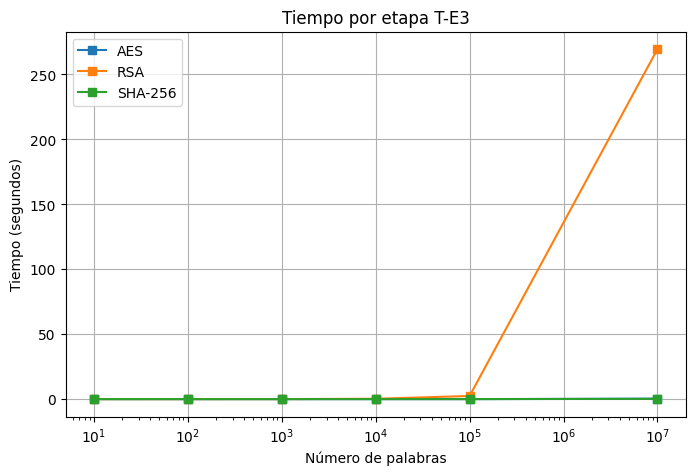

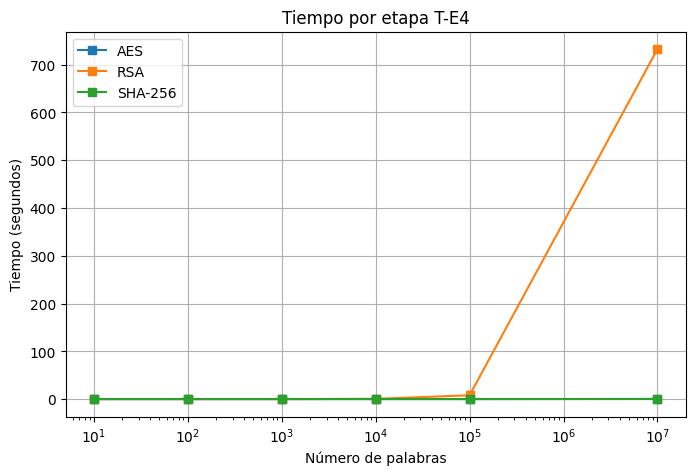

In [ ]:
etapas = ["T-E1", "T-E2", "T-E3", "T-E4"]

for etapa in etapas:
    plt.figure(figsize=(8,5))
    for nombre, grupo in agrupado:
        plt.plot(grupo["#Palabras"], grupo[etapa], marker='s', label=nombre)
    plt.title(f"Tiempo por etapa {etapa}")
    plt.xlabel("Número de palabras")
    plt.ylabel("Tiempo (segundos)")
    plt.legend()
    plt.grid(True)
    plt.xscale('log')
    plt.show()


### Gráfico de barras resumen

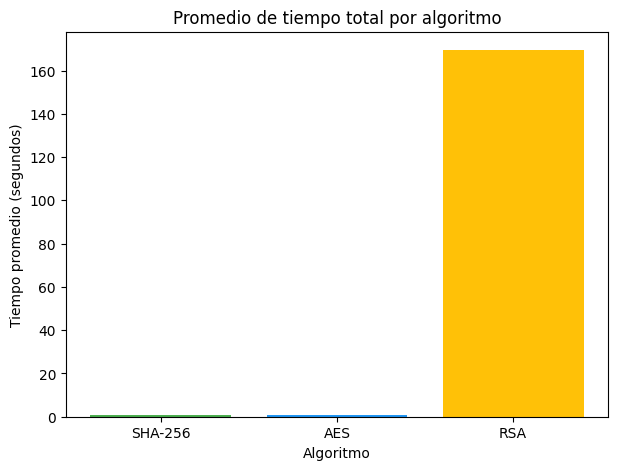

In [ ]:
promedios = df.groupby("Algoritmo")["T-Total"].mean().sort_values()

plt.figure(figsize=(7,5))
plt.bar(promedios.index, promedios.values, color=['#4CAF50', '#2196F3', '#FFC107'])
plt.title("Promedio de tiempo total por algoritmo")
plt.ylabel("Tiempo promedio (segundos)")
plt.xlabel("Algoritmo")
plt.show()


### Guardar gráfico final en Drive (opcional)

In [ ]:
ruta_grafico = OUTPUT_DIR / "grafico_comparativo.png"

plt.figure(figsize=(10,6))
for nombre, grupo in agrupado:
    plt.plot(grupo["#Palabras"], grupo["T-Total"], marker='o', label=nombre)
plt.title("Comparativa de tiempos totales (guardado)")
plt.xlabel("Número de palabras")
plt.ylabel("Tiempo total (s)")
plt.legend()
plt.grid(True)
plt.xscale('log')
plt.savefig(ruta_grafico)
plt.close()

print(f"🖼️ Gráfico guardado correctamente en: {ruta_grafico}")


🖼️ Gráfico guardado correctamente en: /content/drive/MyDrive/Grupo6_Cifrados/outputs/grafico_comparativo.png
